In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import model as modellib, utils



2023-05-13 13:08:28.693181: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 13:08:29.665073: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30984 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB, pci bus id: 0000:59:00.0, compute capability: 7.0


In [2]:
class FrogConfig(Config):
    """Configuration for training on the frog dataset.
    Derives from the base Config class and overrides values specific
    to the frog dataset.
    """
    # Give the configuration a recognizable name
    NAME = "frog"
    
    BACKBONE = "resnet50"

    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + customLabel

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
config = FrogConfig()
config.display()




Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        35
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [3]:
from collections import defaultdict
from PIL import Image

class FrogDataset(utils.Dataset):
    def load_frog(self, dataset_dir, subset, annotations_path):
        """Load a subset of the Frog dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val or test
        annotations_path: Path to COCO annotations json file.
        """
        # Add classes. We have only one class to add.
        self.add_class("frog", 1, "frog_stomach")

        assert subset in ["train", "val", "test"]

        # Load annotations
        annotations = json.load(open(annotations_path))
        annotations_img = {int(a['id']): a for a in annotations['images']}
        annotations_ann = defaultdict(list)
        for a in annotations['annotations']:
            annotations_ann[a['image_id']].append(a)

        # Add images
        for image_id, image in annotations_img.items():
            image_path = os.path.join(dataset_dir, image['file_name'])
            w, h = Image.open(image_path).size
            self.add_image(
                'frog', 
                image_id=image_id, 
                path=image_path, 
                width=w, 
                height=h, 
                annotations=annotations_ann[image_id])

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a frog dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "frog":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["annotations"])], dtype=np.uint8)
        for i, ann in enumerate(info["annotations"]):
            # Get indexes of pixels inside the polygon and set them to 1
            for segmentation in ann['segmentation']:
                segmentation = np.asarray(segmentation)
                segmentation = np.reshape(segmentation, (int(segmentation.shape[-1] / 2), 2))
                rr, cc = skimage.draw.polygon(segmentation[:, 1], segmentation[:, 0]) 
                mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(bool), np.ones([mask.shape[-1]], dtype=np.int32)



    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "frog":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [4]:
data_dir = "data/images"

In [5]:
# Training dataset.
dataset_train = FrogDataset()
dataset_train.load_frog(data_dir, "train", "data/split_segmentation_data/train.json")
dataset_train.prepare()

# Validation dataset
dataset_val = FrogDataset()
dataset_val.load_frog(data_dir, "val", "data/split_segmentation_data/val.json")
dataset_val.prepare()

# Load testing dataset
dataset_test = FrogDataset()
dataset_test.load_frog(data_dir, "test", "data/split_segmentation_data/test.json")
dataset_test.prepare()

In [6]:
# Number of training images
num_train_images = len(dataset_train.image_ids)
print(f"Number of training images: {num_train_images}")

# Number of validation images
num_val_images = len(dataset_val.image_ids)
print(f"Number of validation images: {num_val_images}")

# Number of test images
num_test_images = len(dataset_test.image_ids)
print(f"Number of test images: {num_test_images}")

# Total number of images
total_images = num_train_images + num_val_images + num_test_images
print(f"Total number of images: {total_images}")


Number of training images: 835
Number of validation images: 179
Number of test images: 179
Total number of images: 1193


# Training

In [7]:
# Create model in training mode
MODEL_DIR = "weights"
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that are different
    # due to the different number of classes. See README for instructions
    # to download the COCO weights
    COCO_MODEL_PATH = "weights/mask_rcnn_coco.h5"
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)



In [8]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: weights/frog20230513T1309/mask_rcnn_frog_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed)
mrc

/opt/conda/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10


/opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_5:0", shape=(Non

  1/100 [..............................] - ETA: 11:41 - batch: 0.0000e+00 - size: 1.0000 - loss: 3.8101 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.3659 - mrcnn_class_loss: 1.3019 - mrcnn_bbox_loss: 1.5620 - mrcnn_mask_loss: 0.5610

2023-05-13 13:10:02.208039: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2023-05-13 13:10:02.208087: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2023-05-13 13:10:02.208135: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1630] Profiler found 1 GPUs
2023-05-13 13:10:02.208565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2023-05-13 13:10:03.135163: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-05-13 13:10:03.135687: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1764] CUPTI activity buffer flushed
2023-05-13 13:10:03.200431: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:526]  GpuTracer has collected 2506 callback api events and 2518 activity events. 
2023-05-13 13:10:03.261110: I

  2/100 [..............................] - ETA: 4:14 - batch: 0.5000 - size: 1.0000 - loss: 2.9440 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.2581 - mrcnn_class_loss: 0.8718 - mrcnn_bbox_loss: 1.2593 - mrcnn_mask_loss: 0.5339     

2023-05-13 13:10:03.371753: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to weights/frog20230513T1309/plugins/profile/2023_05_13_13_10_03/jupyter-nicolaiep.trace.json.gz
2023-05-13 13:10:03.458340: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: weights/frog20230513T1309/plugins/profile/2023_05_13_13_10_03

2023-05-13 13:10:03.465755: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to weights/frog20230513T1309/plugins/profile/2023_05_13_13_10_03/jupyter-nicolaiep.memory_profile.json.gz
2023-05-13 13:10:03.469800: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: weights/frog20230513T1309/plugins/profile/2023_05_13_13_10_03
Dumped tool data for xplane.pb to weights/frog20230513T1309/plugins/profile/2023_05_13_13_10_03/jupyter-nicolaiep.xplane.pb
Dumped tool data for overview_page.pb to weights/frog20230513T

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.7691 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.2185 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.3655 - mrcnn_mask_loss: 0.1353

/opt/conda/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


100/100 [==============================] - 154s 1s/step - batch: 49.5000 - size: 1.0000 - loss: 0.7691 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.2185 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.3655 - mrcnn_mask_loss: 0.1353 - val_loss: 0.3602 - val_rpn_class_loss: 0.0031 - val_rpn_bbox_loss: 0.0883 - val_mrcnn_class_loss: 0.0186 - val_mrcnn_bbox_loss: 0.1540 - val_mrcnn_mask_loss: 0.0962
Epoch 2/10
100/100 [==============================] - 138s 1s/step - batch: 49.5000 - size: 1.0000 - loss: 0.3388 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1178 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.1194 - mrcnn_mask_loss: 0.0892 - val_loss: 0.3332 - val_rpn_class_loss: 0.0010 - val_rpn_bbox_loss: 0.1413 - val_mrcnn_class_loss: 0.0084 - val_mrcnn_bbox_loss: 0.1027 - val_mrcnn_mask_loss: 0.0797
Epoch 3/10
100/100 [==============================] - 135s 1s/step - batch: 49.5000 - size: 1.0000 - loss: 0.3556 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1689 - mrcnn_class_loss: 0.0104 - m

In [9]:
history1 = model.keras_model.history.history

In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=25, 
            layers="all")


Starting at epoch 10. LR=0.0001

Checkpoint Path: weights/frog20230513T1309/mask_rcnn_frog_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNo

/opt/conda/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 11/25


/opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_5:0", 

  1/100 [..............................] - ETA: 11:38 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.2965 - rpn_class_loss: 3.7673e-04 - rpn_bbox_loss: 0.0426 - mrcnn_class_loss: 0.0052 - mrcnn_bbox_loss: 0.0176 - mrcnn_mask_loss: 0.0826

2023-05-13 13:33:27.604636: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2023-05-13 13:33:27.604682: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2023-05-13 13:33:28.609481: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-05-13 13:33:28.610677: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1764] CUPTI activity buffer flushed
2023-05-13 13:33:28.716888: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:526]  GpuTracer has collected 5863 callback api events and 5892 activity events. 
2023-05-13 13:33:28.867966: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2023-05-13 13:33:29.035447: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: weights/frog20230513T1309/plugins/profile/2023_05_13_13_33_28

2023-05-13 13:33:29.142328: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] 

  2/100 [..............................] - ETA: 4:25 - batch: 0.5000 - size: 1.0000 - loss: 0.4322 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0579 - mrcnn_class_loss: 0.0061 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.1199         

2023-05-13 13:33:29.347808: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to weights/frog20230513T1309/plugins/profile/2023_05_13_13_33_28/jupyter-nicolaiep.memory_profile.json.gz
2023-05-13 13:33:29.356147: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: weights/frog20230513T1309/plugins/profile/2023_05_13_13_33_28
Dumped tool data for xplane.pb to weights/frog20230513T1309/plugins/profile/2023_05_13_13_33_28/jupyter-nicolaiep.xplane.pb
Dumped tool data for overview_page.pb to weights/frog20230513T1309/plugins/profile/2023_05_13_13_33_28/jupyter-nicolaiep.overview_page.pb
Dumped tool data for input_pipeline.pb to weights/frog20230513T1309/plugins/profile/2023_05_13_13_33_28/jupyter-nicolaiep.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to weights/frog20230513T1309/plugins/profile/2023_05_13_13_33_28/jupyter-nicolaiep.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb 

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.3370 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0697 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0623

/opt/conda/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


100/100 [==============================] - 156s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.3370 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0697 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0623 - val_loss: 0.3185 - val_rpn_class_loss: 8.3281e-04 - val_rpn_bbox_loss: 0.0504 - val_mrcnn_class_loss: 0.0080 - val_mrcnn_bbox_loss: 0.0217 - val_mrcnn_mask_loss: 0.0783
Epoch 12/25
100/100 [==============================] - 142s 1s/step - batch: 49.5000 - size: 1.0000 - loss: 0.2878 - rpn_class_loss: 7.7318e-04 - rpn_bbox_loss: 0.0479 - mrcnn_class_loss: 0.0051 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.0638 - val_loss: 0.3310 - val_rpn_class_loss: 0.0019 - val_rpn_bbox_loss: 0.0648 - val_mrcnn_class_loss: 0.0110 - val_mrcnn_bbox_loss: 0.0315 - val_mrcnn_mask_loss: 0.0563
Epoch 13/25
100/100 [==============================] - 143s 1s/step - batch: 49.5000 - size: 1.0000 - loss: 0.2764 - rpn_class_loss: 9.2468e-04 - rpn_bbox_loss: 0.0522 - mrcnn_class_lo

In [12]:
history2 = model.keras_model.history.history

In [13]:
# Combine the history
for key in history1.keys():
    history1[key].extend(history2[key])
    
history = history1

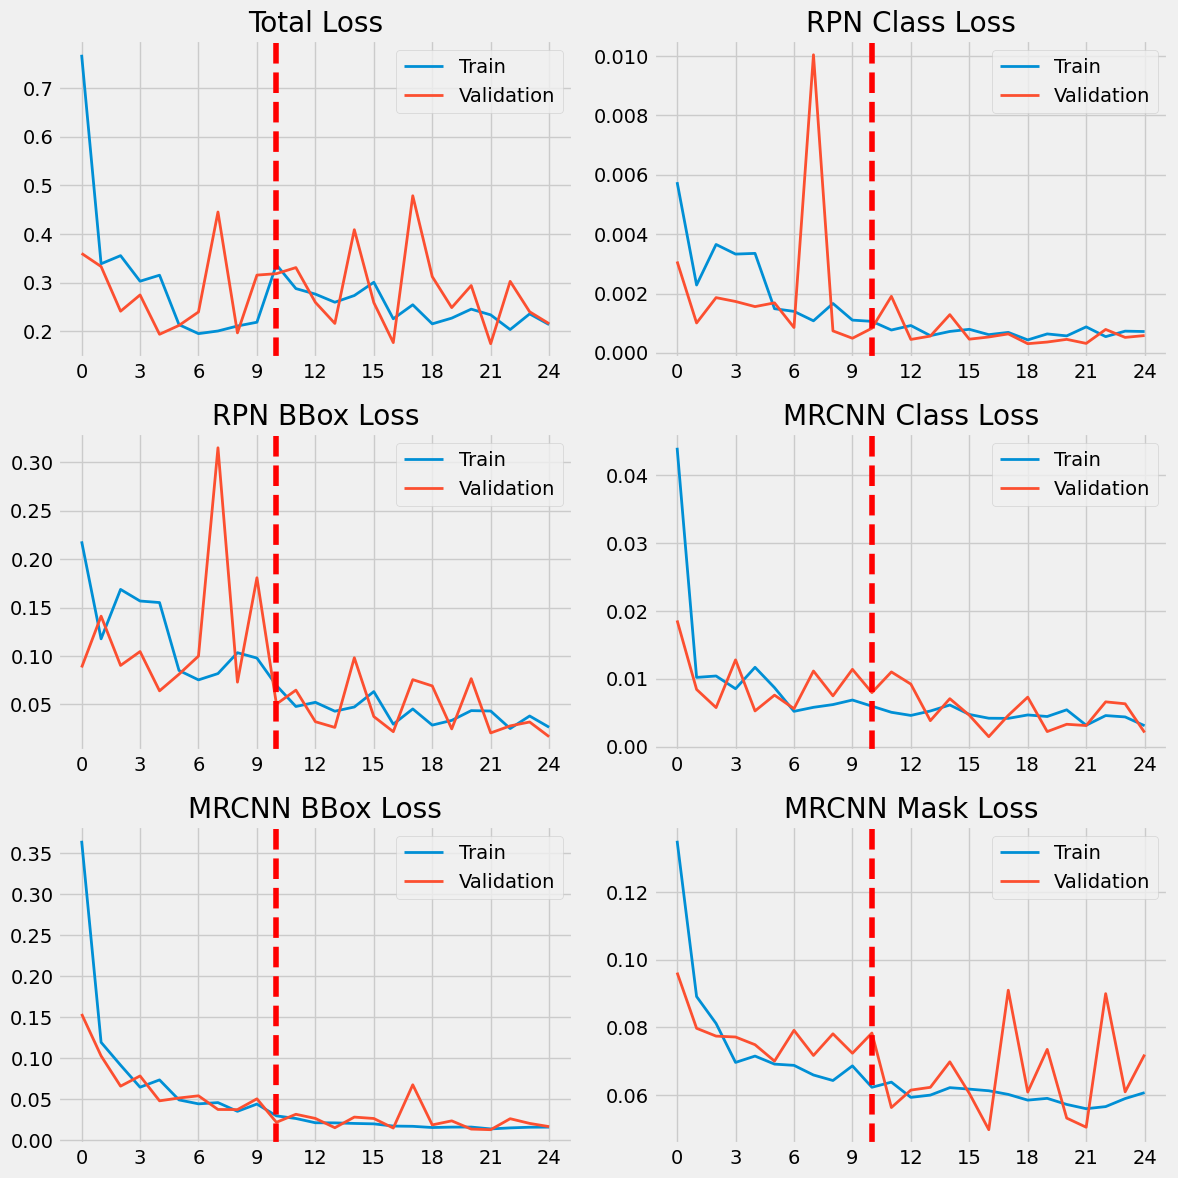

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


# Setting a style to use
plt.style.use('fivethirtyeight')

# Plot the training history
fig, ax = plt.subplots(3, 2, figsize=(12, 12))

# Creating subplots for each metric
metrics = [('loss', 'Total Loss'), ('rpn_class_loss', 'RPN Class Loss'), 
           ('rpn_bbox_loss', 'RPN BBox Loss'), ('mrcnn_class_loss', 'MRCNN Class Loss'),
           ('mrcnn_bbox_loss', 'MRCNN BBox Loss'), ('mrcnn_mask_loss', 'MRCNN Mask Loss')]

for i, metric in enumerate(metrics):
    train_metric = history[metric[0]]
    val_metric = history['val_' + metric[0]]

    # Plot the metric
    ax[i//2, i%2].plot(train_metric, label='Train', linewidth=2)
    ax[i//2, i%2].plot(val_metric, label='Validation', linewidth=2)
    
    # Add a vertical line at the 5th epoch
    ax[i//2, i%2].axvline(x=10, color='r', linestyle='--')

    # Setting plot title
    ax[i//2, i%2].set_title(metric[1])

    # Making the x-axis display integers only
    ax[i//2, i%2].xaxis.set_major_locator(MaxNLocator(integer=True))

    # Adding legend to the plot
    ax[i//2, i%2].legend()

# Ensuring the subplots do not overlap
plt.tight_layout()

# Saving the figure as a png file
plt.savefig('training_history.png', dpi=300)

# Displaying the plot
plt.show()


# Testing

In [17]:
class InferenceConfig(FrogConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
test_model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir='logs')

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = "weights/frog20230513T1309/mask_rcnn_frog_0025.h5"
#model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
test_model.load_weights(model_path, by_name=True)


Loading weights from  weights/frog20230513T1309/mask_rcnn_frog_0025.h5
Re-starting from epoch 25


In [18]:
import numpy as np
from tqdm.notebook import tqdm

# Define IoU thresholds
iou_thresholds = [0.5, 0.75] + [t / 100.0 for t in range(50, 95, 5)]

# Initialize lists to hold precision values
iou_precisions = [[] for _ in iou_thresholds]

image_ids = dataset_test.image_ids
APs = []
Precisions = []
Recalls = []
F1s = []
IoUs = []

for image_id in tqdm(image_ids):  # use tqdm for a progress bar
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = test_model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    # Precision, Recall, and F1 Score
    precision = np.mean(precisions)
    recall = np.mean(recalls)
    f1 = (2 * (precision * recall)) / (precision + recall)
    Precisions.append(precision)
    Recalls.append(recall)
    F1s.append(f1)
    # IoU
    IoU = utils.compute_overlaps_masks(gt_mask, r['masks']).mean()
    IoUs.append(IoU)

    # Compute overlaps of predicted masks with ground truth masks
    overlaps = utils.compute_overlaps_masks(gt_mask, r['masks'])
    
    # Compute precisions at various IoU thresholds
    for i, thr in enumerate(iou_thresholds):
        tp = np.sum(overlaps >= thr)
        fp = np.sum(overlaps < thr)
        if tp + fp > 0:
            precision = tp / (tp + fp)
        else:
            precision = 1.0
        iou_precisions[i].append(precision)

# Compute average precision at each IoU threshold
aps = [np.mean(prec) for prec in iou_precisions]


for thr, ap in zip(iou_thresholds, aps):
    print(f"AP at IoU={thr}: {ap}")
print("mAP: ", np.mean(APs))
print("Mean Precision: ", np.mean(Precisions))
print("Mean Recall: ", np.mean(Recalls))
print("Mean F1 Score: ", np.mean(F1s))
print("Mean IoU: ", np.mean(IoUs))

  0%|          | 0/179 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AP at IoU=0.5: 1.0
AP at IoU=0.75: 1.0
AP at IoU=0.5: 1.0
AP at IoU=0.55: 1.0
AP at IoU=0.6: 1.0
AP at IoU=0.65: 1.0
AP at IoU=0.7: 1.0
AP at IoU=0.75: 1.0
AP at IoU=0.8: 1.0
AP at IoU=0.85: 0.9776536312849162
AP at IoU=0.9: 0.8435754189944135
mAP:  1.0
Mean Precision:  0.6666666666666667
Mean Recall:  0.6666666666666667
Mean F1 Score:  0.6666666666666667
Mean IoU:  0.9185711


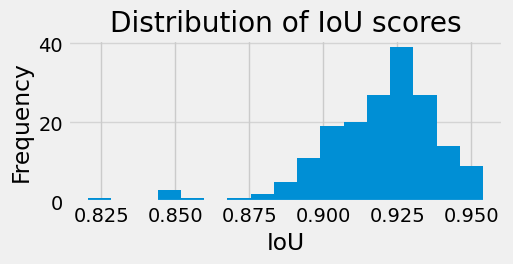

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 2))
plt.hist(IoUs, bins='auto')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.title('Distribution of IoU scores')
plt.grid(axis='y', alpha=0.75)
plt.show()


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


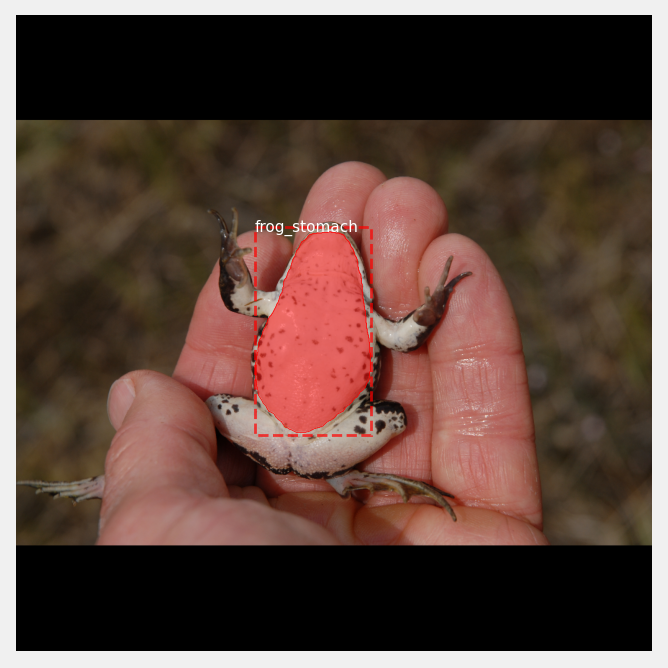

In [20]:
import random
from mrcnn import visualize

# Load a random image from the test dataset
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id)

# Get the prediction result
results = test_model.detect([original_image], verbose=1)
r = results[0]

# Display original image without segmentation
#plt.figure(figsize=(8,8))
#plt.imshow(original_image)
#plt.axis('off')
#plt.title("Original Image")
#plt.show()

# Display the original image and the predicted mask
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], figsize=(8, 8))
